In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("data.csv")[1:]
data = data.loc[data.area <= 120]  # Remove anomalies
data['living_area'] = data['living_area'] / data['area']  # Percent of living area
data['kitchen_area'] = data['kitchen_area'] / data['area']  # Percent of kitchen area
data = data.drop(columns=['link'])
data['has_balcony'] = data['has_balcony'].map(lambda x: 1 if x == 'True' else 0)
data['has_renovation'] = data['has_renovation'].map(lambda x: 1 if x == 'True' else 0)
data['area'] = data['area'] / max(data['area'])
data['floor'] = data['floor'] / max(data['floor'])
data['price'] = data['price'] / max(data['price'])
X, y = data.loc[:, data.columns != 'has_renovation'], data['has_renovation']
print(X)

         price     floor      area  living_area  kitchen_area  has_balcony
1     0.056532  0.538462  0.391964     0.378132      0.321185            1
2     0.049955  0.538462  0.413393     0.315335      0.576674            0
3     0.051351  0.884615  0.458036     0.456140      0.267057            1
4     0.074324  0.153846  0.348214     0.315385      0.425641            0
5     0.053378  0.153846  0.312500     0.357143      0.414286            0
...        ...       ...       ...          ...           ...          ...
1282  0.033557  0.076923  0.519643     0.415808      0.293814            0
1283  0.033318  0.076923  0.489196     0.414309      0.282898            0
1284  0.033253  0.076923  0.585714     0.579268      0.234756            0
1285  0.033313  0.076923  0.348214     0.315385      0.400000            1
1286  0.033109  0.076923  0.355982     0.426386      0.270880            1

[1279 rows x 6 columns]


In [2]:
print(X.columns)

Index(['price', 'floor', 'area', 'living_area', 'kitchen_area', 'has_balcony'], dtype='object')


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [4]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=20)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [5]:
from sklearn.metrics import balanced_accuracy_score

prediction = classifier.predict(X_test)
print(balanced_accuracy_score(prediction, y_test))

0.7857142857142857


In [6]:
for x in X_test.iterrows():
    print(x, type(x))

(1070, price           0.029505
floor           0.038462
area            0.305536
living_area     0.409117
kitchen_area    0.303916
has_balcony     1.000000
Name: 1070, dtype: float64) <class 'tuple'>
(966, price           0.026352
floor           0.038462
area            0.292500
living_area     0.305250
kitchen_area    0.463980
has_balcony     1.000000
Name: 966, dtype: float64) <class 'tuple'>
(462, price           0.036932
floor           0.269231
area            0.537500
living_area     0.395349
kitchen_area    0.415282
has_balcony     0.000000
Name: 462, dtype: float64) <class 'tuple'>
(691, price           0.062613
floor           0.192308
area            0.568750
living_area     0.748823
kitchen_area    0.167975
has_balcony     1.000000
Name: 691, dtype: float64) <class 'tuple'>
(490, price           0.038694
floor           0.076923
area            0.369643
living_area     0.507246
kitchen_area    0.289855
has_balcony     0.000000
Name: 490, dtype: float64) <class 'tuple'>
(92

In [7]:
from knn import KnnClassifier, even_kernel, MinkovskyMetrics

my_classifier = KnnClassifier(even_kernel, MinkovskyMetrics(2), k=20)

In [8]:
my_classifier.fit(X_train, y_train)
predicted = my_classifier.predict(X_test)
print(balanced_accuracy_score(predicted, y_test))

0.7882069629833494


In [9]:
from knn import triangle

my_classifier = KnnClassifier(triangle, MinkovskyMetrics(2), k=10).fit(X_train, y_train)
weights = my_classifier.get_lowess_weights()
print(balanced_accuracy_score(my_classifier.predict(X_valid, weights), y_valid))

0.5977653631284916


/home/burprop/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


20 0.7738095238095238 20 0.7738095238095238


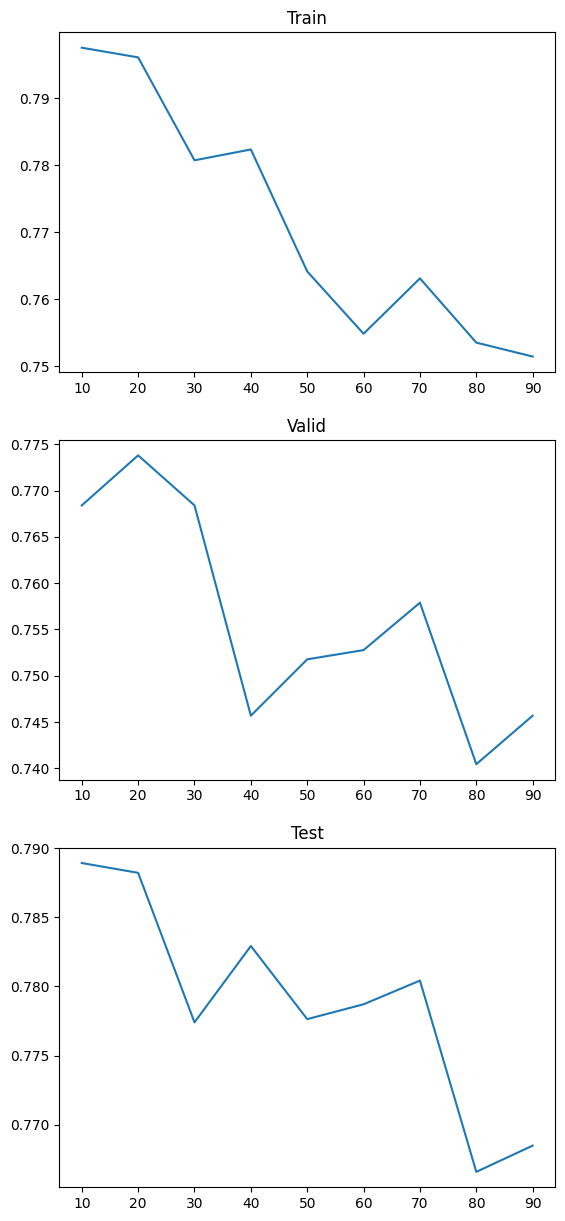

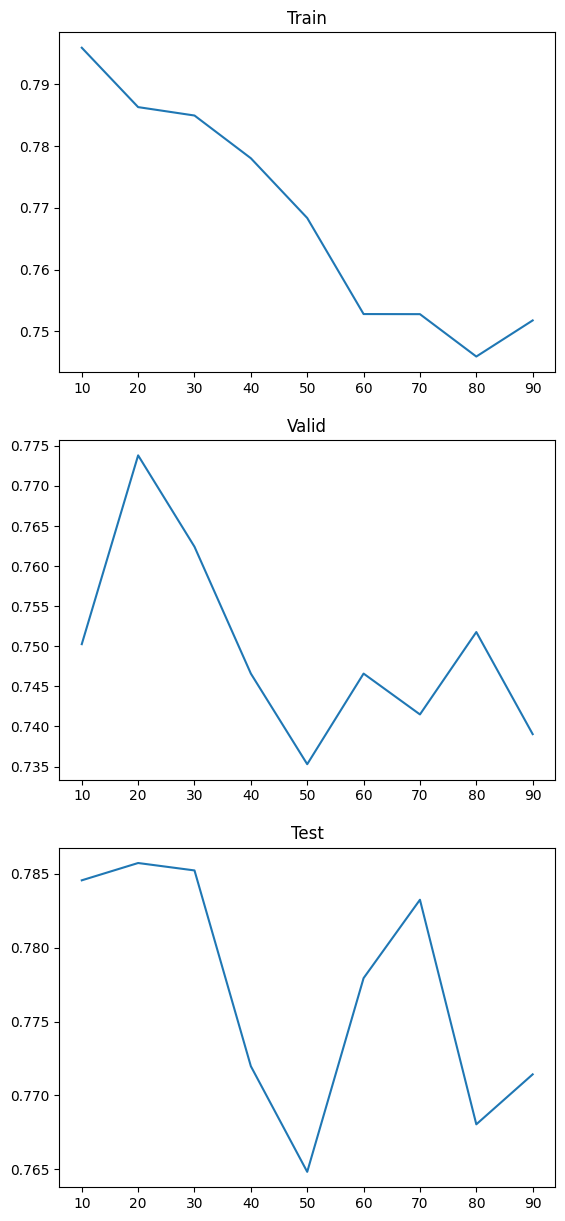

In [10]:
from matplotlib import pyplot as plt

my_max = 0
my_max_k = None
lib_max = 0
lib_max_k = None
my_accuracies = []
lib_accuracies = []


def get_metrics(clsf):
    return balanced_accuracy_score(clsf.predict(X_train), y_train), balanced_accuracy_score(
        clsf.predict(X_valid), y_valid), balanced_accuracy_score(
        clsf.predict(X_test), y_test)


def diff_metrics_data(arr):
    return [list(map(lambda x: x[it], arr)) for it in range(3)]


def make_plots(plots_data, rng):
    s1, s2, s3 = diff_metrics_data(plots_data)
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.set_figheight(15)
    ax1.plot(rng, s1)
    ax1.set_title("Train")
    ax2.plot(rng, s2)
    ax2.set_title("Valid")
    ax3.plot(rng, s3)
    ax3.set_title("Test")


for k in range(10, 100, 10):
    my_classifier = KnnClassifier(even_kernel, MinkovskyMetrics(2), k=k).fit(X_train, y_train)
    lib_classifier = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    my_accuracies.append(get_metrics(my_classifier))
    lib_accuracies.append(get_metrics(lib_classifier))
    if my_accuracies[-1][1] > my_max:
        my_max = my_accuracies[-1][1]
        my_max_k = k
    if lib_accuracies[-1][1] > lib_max:
        lib_max = lib_accuracies[-1][1]
        lib_max_k = k
print(my_max_k, my_max, lib_max_k, lib_max)
make_plots(my_accuracies, range(10, 100, 10))
make_plots(lib_accuracies, range(10, 100, 10))

In [11]:
weights

[1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [12]:
X_train_sample = X_train
y_train_sample = y_train
for ind, row in enumerate(X_train_sample.iterrows()):
    if weights[ind] == 0:
        X_train_sample = X_train_sample.drop([row[0]])
        y_train_sample = y_train_sample.drop([row[0]])
print(len(X_train_sample), len(X_train))
lib_classifier = KNeighborsClassifier(n_neighbors=80).fit(X_train_sample, y_train_sample)

469 716


In [13]:
print(balanced_accuracy_score(lib_classifier.predict(X_valid), y_valid))

0.709305373525557
